<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/Quasi_Newton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[source](https://github.com/amkatrutsa/MIPT-Opt/blob/master/Spring2020/newton_quasi.ipynb) 

# Analytical center

Consider the unconstrained problem:

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_{x \in \mathbb{R}^n}
$$

with variable $x \in \mathbb{R}^n$, and $\text{dom} f = \{x \mid a_i^{\top}x < 1, i = 1, \ldots , m, \quad |x_i| < 1, i = 1, \ldots , n\}$.
This is the problem of computing the analytic center of the set of linear inequalities:

$$
a_i^{\top}x < 1, \;\; i = 1,\ldots, m, \qquad |x_i| < 1, \;\; i = 1, \ldots, n
$$

Note that we can choose $x_0 = 0$ as our initial point. You can generate instances of this problem by choosing ai from some distribution on $\mathbb{R}^n$.

In [2]:
!pip install git+https://github.com/amkatrutsa/liboptpy --quiet

In [3]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as scopt

In [4]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

In [5]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [6]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [7]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
    "LBFGS": methods.fo.LBFGS(f, grad_f),
}

In [8]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6394985253702
Norm of gradient = 5.307270534714855e-06
	 Method BFGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.6394985253627
Norm of gradient = 6.831344217018925e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.639150817649
Norm of gradient = 0.04829111558095041
	 Method LBFGS
Required tolerance achieved!
Convergence in 14 iterations
Function value = -706.6394985253712
Norm of gradient = 3.4088009169079247e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 17 iterations
Function value = -706.6394985252459


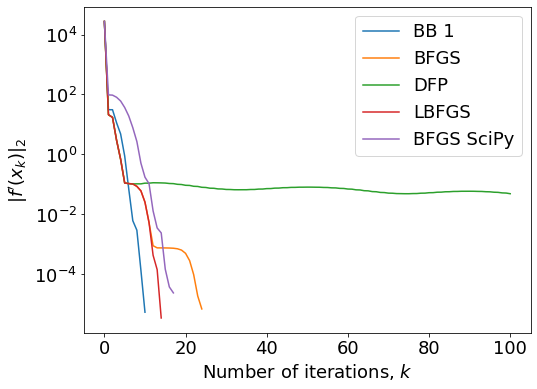

In [9]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [ ]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})

	 Method BB 1
100 loops, best of 5: 12.6 ms per loop
	 Method BFGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


1 loop, best of 5: 4.5 s per loop
	 Method DFP


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


1 loop, best of 5: 10.4 s per loop
	 Method LBFGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


10 loops, best of 5: 134 ms per loop


# Ill-conditioned linear system

In [ ]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 49.99999999999879


In [ ]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [ ]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
    "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "DFP": methods.fo.DFP(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
    "LBFGS": methods.fo.LBFGS(f, gradf, hist_size=10),
}

In [ ]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")

scopt_lbfgs_conv = []
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, 
                           options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-6},
                           callback=lambda x: scopt_lbfgs_conv.append(x),
                           )
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 61 iterations
Function value = -2.295939525010034
Norm of gradient = 9.894730436306648e-06
	 Method BB 2
Required tolerance achieved!
Convergence in 61 iterations
Function value = -2.2959395250499366
Norm of gradient = 6.080438850772609e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 46 iterations
Function value = -2.295939525053618
Norm of gradient = 9.37591825251349e-06
	 Method DFP
Required tolerance achieved!
Convergence in 94 iterations
Function value = -2.2959395250538384
Norm of gradient = 6.7342344771832965e-06
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -2.295937456619326
Norm of gradient = 0.0028971279348261876
	 Method LBFGS
Required tolerance achieved!
Convergence in 44 iterations
Function value = -2.2959395250334835
Norm of gradient = 9.89422958724675e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 59 iterations
Function val

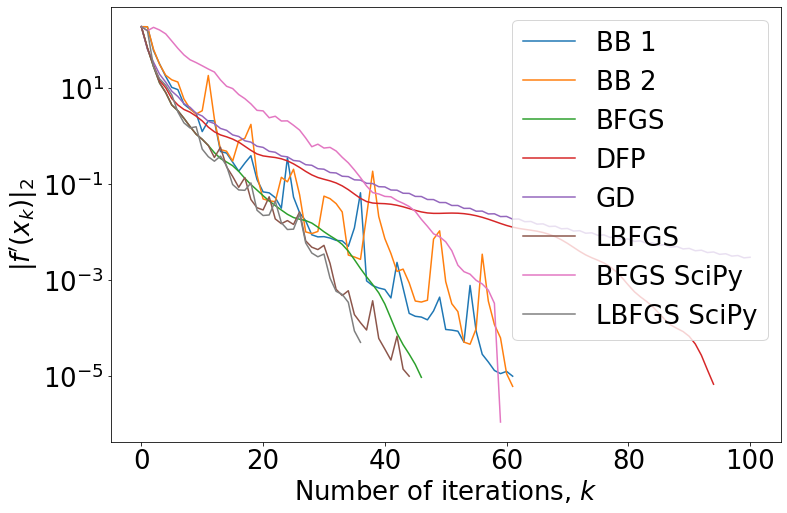

In [ ]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:   
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_lbfgs_conv], label='LBFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [ ]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=gradf, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-6})

	 Method BB 1
The slowest run took 6.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.17 ms per loop
	 Method BB 2
1000 loops, best of 3: 1.16 ms per loop
	 Method BFGS
100 loops, best of 3: 5.09 ms per loop
	 Method DFP
100 loops, best of 3: 8.96 ms per loop
	 Method GD
100 loops, best of 3: 2.12 ms per loop
	 Method LBFGS
100 loops, best of 3: 6.12 ms per loop
100 loops, best of 3: 9.05 ms per loop
1000 loops, best of 3: 1.3 ms per loop
